## Introduction to the file

In this file, the trained models are loaded and compared. The first cells are still necessary to initialise the model and the normalisers. The first cell that shows the results will be properly marked  

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from optuna.trial import TrialState

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns
import time

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

In [2]:
def f_exact(x, t):
    return torch.cos(t) - torch.pi/2*torch.sin(x)*torch.cos(t)

def u_exact(x, t):
    return torch.pi/2*torch.sin(x)*torch.cos(t)

def theta_exact(x, t):
    return (torch.pi/2*torch.cos(x) + (x - torch.pi/2)) * torch.cos(t)

In [3]:
L = torch.pi
t_end = 2*torch.pi

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [5]:
def load_norm(mean, std):
    n = type("normUnitvar", (), {})()
    n.normmean = mean
    n.normstd = std
    n.normalize = lambda x: (x - n.normmean) / n.normstd
    n.denormalize = lambda y: y * n.normstd + n.normmean
    return n

In [6]:
class MLP(nn.Module):
    "Defines a basic multi-layer perceptron."
    def __init__(self, input_size, hidden_size, output_size, num_hid_layers=4):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.num_hid_layers = num_hid_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))

        for n in range(num_hid_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, ):
        # Define the forward pass
        for i, layer in enumerate(self.layers):
            x = torch.tanh(layer(x))  # Activation function (Tanh) after each layer
        x = self.fc_out(x)          # Output layer
        return x

In [7]:
def plot_x_vs_u_at_times(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True, ax=None, norms=None):
    if norms is None:    
        raise ValueError("Please provide normalizers")
    
    x_normalizer = load_norm(norms["x_mean"].to(device), norms["x_std"].to(device))
    t_normalizer = load_norm(norms["t_mean"].to(device), norms["t_std"].to(device))
    u_normalizer = load_norm(norms["u_mean"].to(device), norms["u_std"].to(device))
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []

    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)

            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            u_pred_output_norm, _ = model(
                torch.cat([x_norm, t_norm], dim=1)
            ).split(1, dim=-1)
            u_pred_output = u_normalizer.denormalize(u_pred_output_norm)

            curves.append((t_val, x.squeeze().cpu(), u_pred_output.squeeze().cpu()))

    for t_val, x_cpu, u_cpu in curves:
        ax.plot(x_cpu.numpy(), u_cpu.numpy(), label=f"pred t={t_val}")

    if with_exact and 'u_exact' in globals():
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            u_true = u_exact(x_t, t_t).detach().cpu().squeeze()
            ax.plot(
                x_t.squeeze().cpu().numpy(),
                u_true.numpy(),
                '--',
                alpha=0.6,
                label=f"true t={t_val}"
            )

    ax.set_xlabel('x')
    ax.set_ylabel('u(x,t)')
    ax.set_title('x vs u(x,t) for selected times')
    ax.legend(ncol=2)


In [8]:
def plot_x_vs_theta_at_times(model, times, Nx=200, L_val=None, with_exact=True, ax=None, norms=None):
    if norms is None:
        raise ValueError("Please provide normalizers via the `norms` argument.")

    x_normalizer = load_norm(norms["x_mean"].to(device), norms["x_std"].to(device))
    t_normalizer = load_norm(norms["t_mean"].to(device), norms["t_std"].to(device))
    theta_normalizer = load_norm(norms["theta_mean"].to(device), norms["theta_std"].to(device))

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
        created_fig = True

    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)

    curves = []
    model.eval()
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)

            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)

            _, theta_pred_norm = model(torch.cat([x_norm, t_norm], dim=1)).split(1, dim=-1)

            theta_pred = theta_normalizer.denormalize(theta_pred_norm)

            curves.append((t_val, x.squeeze().cpu(), theta_pred.squeeze().cpu()))

    for t_val, x_cpu, theta_cpu in curves:
        ax.plot(x_cpu.numpy(), theta_cpu.numpy(), label=f"pred t={t_val}")

    if with_exact and 'theta_exact' in globals():
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            theta_true = theta_exact(x_t, t_t).detach().cpu().squeeze()
            ax.plot(
                x_t.squeeze().cpu().numpy(),
                theta_true.numpy(),
                '--', alpha=0.6, label=f"true t={t_val}"
            )

    ax.set_xlabel('x')
    ax.set_ylabel('theta(x,t)')
    ax.set_title('x vs theta(x,t) for selected times')
    ax.legend(ncol=2)

    if created_fig:
        plt.tight_layout()
        plt.show()


In [9]:
def compute_grid_relative_error(pinn_model, norms=None):
    Nx, Nt = 200, 200
    xv = np.linspace(0, np.pi, Nx)
    tv = np.linspace(0, 1, Nt)
    X, T = np.meshgrid(xv, tv, indexing="ij")          # X,T shape: (Nx, Nt)

    xg = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device)
    tg = torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device)
    if norms is not None:
        x_normalizer = load_norm(norms["x_mean"].to(device), norms["x_std"].to(device))
        t_normalizer = load_norm(norms["t_mean"].to(device), norms["t_std"].to(device))
        u_normalizer = load_norm(norms["u_mean"].to(device), norms["u_std"].to(device))
        theta_normalizer = load_norm(norms["theta_mean"].to(device), norms["theta_std"].to(device))
    else:
        raise ValueError("Please provide normalizers")

    xg_n = x_normalizer.normalize(xg)
    tg_n = t_normalizer.normalize(tg)

    with torch.no_grad():
        out_n = pinn_model(torch.cat([xg_n, tg_n], dim=1))
        u_n, theta_n = out_n.split(1, dim=-1)

    u_pred = u_normalizer.denormalize(u_n).cpu().numpy().reshape(Nx, Nt)
    theta_pred = theta_normalizer.denormalize(theta_n).cpu().numpy().reshape(Nx, Nt)

    u_true = u_exact(xg, tg).cpu().numpy().reshape(Nx, Nt)
    theta_true = theta_exact(xg, tg).cpu().numpy().reshape(Nx, Nt)

    R_u = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true) * 100
    R_theta = np.linalg.norm(theta_pred - theta_true) / np.linalg.norm(theta_true) * 100

    print(f"Grid relative error (u):     {R_u:.6f}%")
    print(f"Grid relative error (theta): {R_theta:.6f}%")

In [10]:
norms_L1 = torch.load("normalizers_L1.pt", map_location=device)
norms_L2 = torch.load("normalizers_L2.pt", map_location=device)

In [11]:
pinn_L1 = MLP(2, 250, 2, num_hid_layers=3).to(device)
pinn_L2 = MLP(2, 100, 2, num_hid_layers=2).to(device)

In [12]:
# Load the best models
pinn_L1.load_state_dict(torch.load("best_pinn_L1"))
pinn_L2.load_state_dict(torch.load("best_pinn_L2"))

<All keys matched successfully>

## Results start here

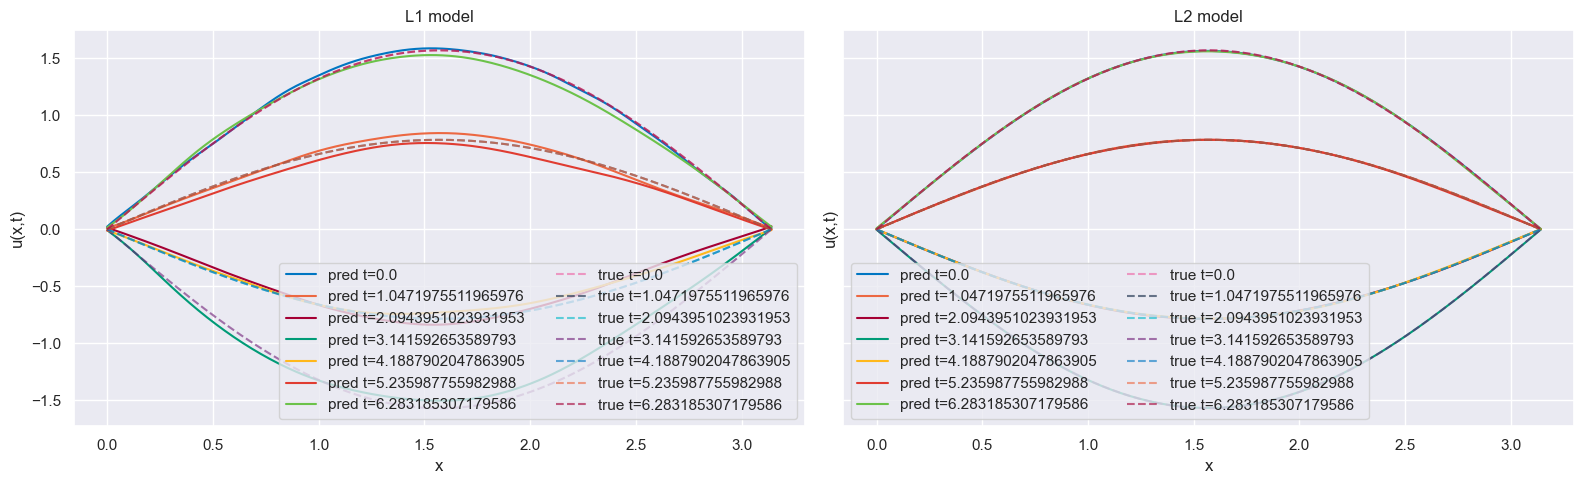

In [13]:
# Plot x vs u(x,t) for multiple time instants using the trained model

# Calculate the new time points: 0, T_end, and 5 evenly spaced times in between
num_times = 7 # 0, t_end, and 5 in between
new_times = np.linspace(0, t_end, num_times)

# Run the plot for both models side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

plot_x_vs_u_at_times(pinn_L1, times=new_times, Nx =300, L_val=L, with_exact=True, ax=axes[0],norms=norms_L1)
axes[0].set_title("L1 model")

plot_x_vs_u_at_times(pinn_L2, times=new_times, Nx =300, L_val=L, with_exact=True, ax=axes[1],norms=norms_L2)
axes[1].set_title("L2 model")

plt.tight_layout()
plt.show()


It can be seen visually that the L2 model almost exactly follows the ground truth, while the L1 model struggles a lot more

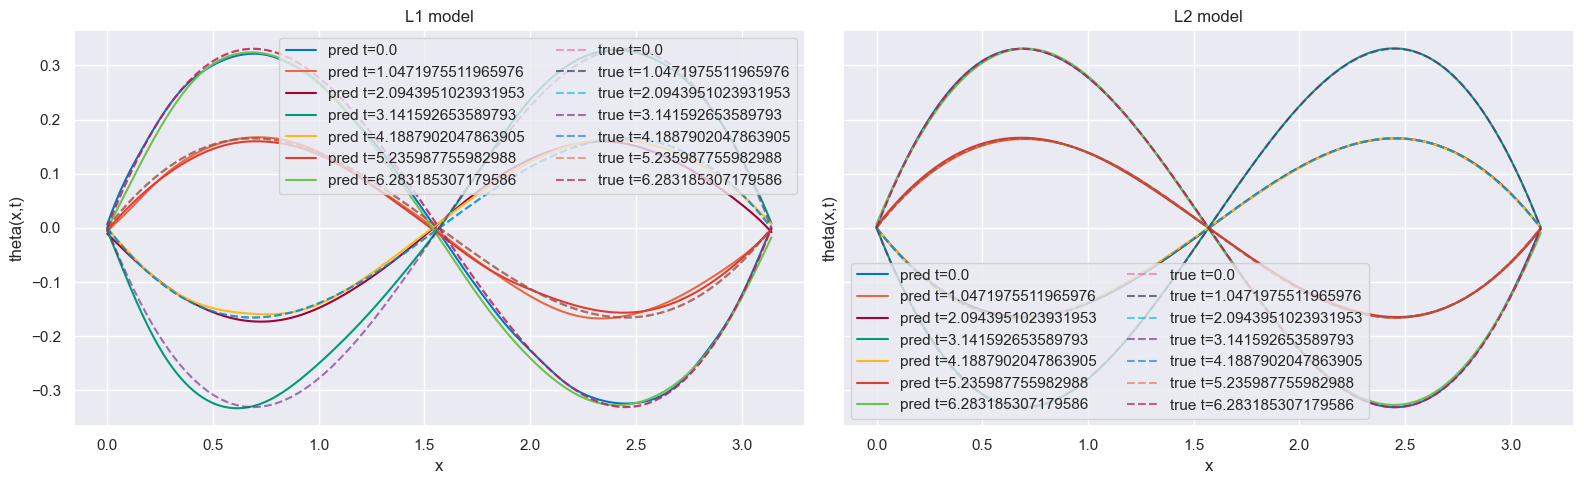

In [14]:
# Now plot the theta for both models side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

plot_x_vs_theta_at_times(pinn_L1, times=new_times, Nx =300, L_val=L, with_exact=True, ax=axes[0],norms=norms_L1)
axes[0].set_title("L1 model")

plot_x_vs_theta_at_times(pinn_L2, times=new_times, Nx =300, L_val=L, with_exact=True, ax=axes[1],norms=norms_L2)
axes[1].set_title("L2 model")

plt.tight_layout()
plt.show()

Again, the theta of the L2 model looks very good, while the L1 model struggles. Visually L2 is the better option for training for this problem. Below we calculate the relative errors for both models to get a quantitative comparison.

In [17]:
print("L1 model relative errors:")
compute_grid_relative_error(pinn_L1, norms=norms_L1)
print("\n")
print("L2 model relative errors:")
compute_grid_relative_error(pinn_L2, norms=norms_L2)

L1 model relative errors:
Grid relative error (u):     2.673239%
Grid relative error (theta): 4.239538%


L2 model relative errors:
Grid relative error (u):     0.202693%
Grid relative error (theta): 0.397274%


These results show that the L2 model is definitely the better fit. Therefore we can conclude L2 is the better option for the loss functions for this particular problem